# Passo 1: Inicialização

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
# Isto é necessário para apresentar os gráficos deste notebook
from plots.chapter6 import *

Finished!


In [ ]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms.v2 import Compose, ToImage, Normalize, \
ToPILImage, Resize, ToDtype
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, \
MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps

# Passo 2: Preparação e Geração dos dados

In [ ]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v2.py


<Figure size 640x480 with 0 Axes>

# Passo 3: Configuração do Modelo

In [ ]:
torch.manual_seed(2)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')


# Passo 4: Registro dos gradientes

In [ ]:
setattr(StepByStep, '_gradients', {})

def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    self._gradients = {}

    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return

setattr(StepByStep, 'capture_gradients', capture_gradients)

# Passo 5: Treinamento do Modelo

In [ ]:
sbs_adam = StepByStep(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader, val_loader)
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

# Passo 6: Visualização

In [ ]:
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

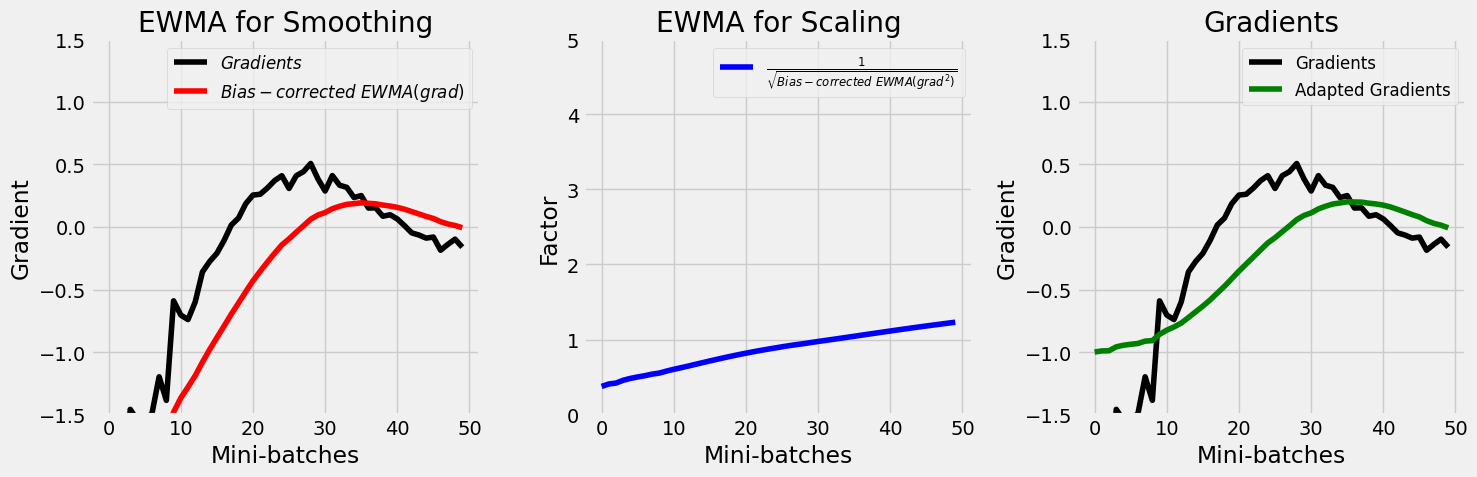

In [ ]:
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

# Passo 7: Comparação entre o SGD e o Adam

In [ ]:
setattr(StepByStep, '_parameters', {})

def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules}

    self._parameters = {}

    for name, layer in modules:
        if name in layers_to_hook:
            self._parameters.update({name: {}})
            for parm_id, p in layer.named_parameters():
                self._parameters[name].update({parm_id: []})

    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())

    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return

setattr(StepByStep, 'capture_parameters', capture_parameters)

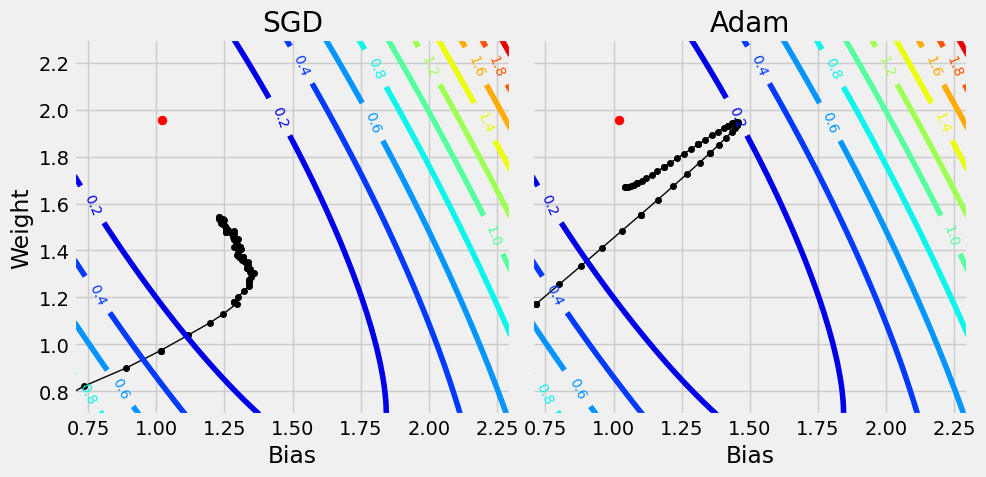

In [ ]:
torch.manual_seed(2)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
             'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}}
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = plot_paths(results, b, w, bs, ws, all_losses)

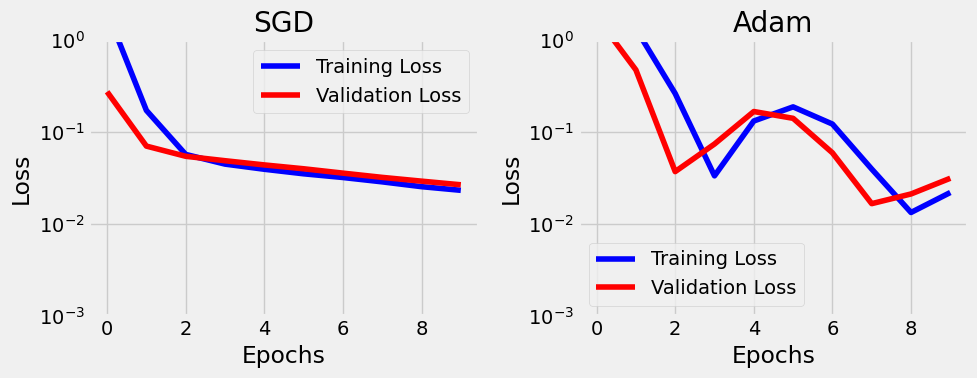

In [ ]:
fig = plot_losses(results)